# HHA 550 - Diabetes Readmission Analysis

# Import Packages

In [ ]:
# !pip install seaborn
# !pip install missingno
# !pip install xgboost
# !pip install catboost
# !pip install regex
# !pip install sklearn
# !pip install pandas
# !pip install numpy
# !pip install imblearn
# !pip install lightgbm
# !pip install ipykernel
# !pip install --upgrade nbformat

In [ ]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import csv 
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline   
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingno as msno
import re 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [ ]:
from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            plot_confusion_matrix, classification_report, plot_roc_curve, f1_score
import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA)

### Start with Loading the CSV Data

In [ ]:
diabetes = pd.read_csv('data/new_diabetic_data_cleaned.csv')

In [ ]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,metformin,change,diabetesMed,readmitted
0,284318214,43985340,0.0,0,0,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,59649570,17397162,0.0,0,1,NaN,0,0,0,0,...,NaN,NaN,0,0,1,1,1,1,0,0
2,67850904,6196320,0.0,1,1,NaN,0,0,0,0,...,NaN,NaN,0,0,1,1,1,1,0,0
3,86008308,6970950,1.0,0,2,NaN,0,0,0,0,...,NaN,NaN,0,0,0,2,0,0,0,0
4,17130798,14532273,0.0,0,1,NaN,0,0,0,0,...,NaN,NaN,0,0,1,1,1,1,0,0


### Insights into our target variable

In [ ]:
print(diabetes['readmitted'] .value_counts())

0    54864
1    35545
2    11357
Name: readmitted, dtype: int64


In [ ]:
diabetes['readmitted'] = diabetes['readmitted'].replace([0,1,2],[0,0,1])

In [ ]:
print(diabetes['readmitted'] .value_counts())

0    90409
1    11357
Name: readmitted, dtype: int64


In [ ]:
y = diabetes['readmitted']
print(f'Percentage of patient readmitted under 30 days: % {round(y.value_counts(normalize=True)[1]*100,2)} --> ({y.value_counts()[1]} patient)\nPercentage of patient not readmitted within 30 days: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} patient)')

Percentage of patient readmitted under 30 days: % 11.16 --> (11357 patient)
Percentage of patient not readmitted within 30 days: % 88.84 --> (90409 patient)


### Visualize readmittance

In [ ]:
fig = px.histogram(diabetes, x="readmitted", title='Readmitted within 30 days', width=400, height=400)
fig.show()

### Check for Missing Data / Missing Values

In [ ]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   encounter_id              101766 non-null  int64  
 1   patient_nbr               101766 non-null  int64  
 2   race                      99493 non-null   float64
 3   gender                    101766 non-null  int64  
 4   age                       101766 non-null  int64  
 5   weight                    3197 non-null    float64
 6   admission_type_id         101766 non-null  int64  
 7   discharge_disposition_id  101766 non-null  int64  
 8   admission_source_id       101766 non-null  int64  
 9   time_in_hospital          101766 non-null  int64  
 10  payer_code                61510 non-null   float64
 11  medical_specialty         51817 non-null   float64
 12  num_lab_procedures        101766 non-null  int64  
 13  num_procedures            101766 non-null  i

In [ ]:
def missing (diabetes):
    missing_number = diabetes.isnull().sum().sort_values(ascending=False)
    missing_percent = (diabetes.isnull().sum()/diabetes.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(diabetes)

,Missing_Number,Missing_Percent
weight,98569,0.968585
medical_specialty,49949,0.490822
payer_code,40256,0.395574
race,2273,0.022336
diag_3,1423,0.013983
diag_2,358,0.003518
diag_1,21,0.000206
encounter_id,0,0.000000
number_inpatient,0,0.000000
diabetesMed,0,0.000000


<AxesSubplot: >

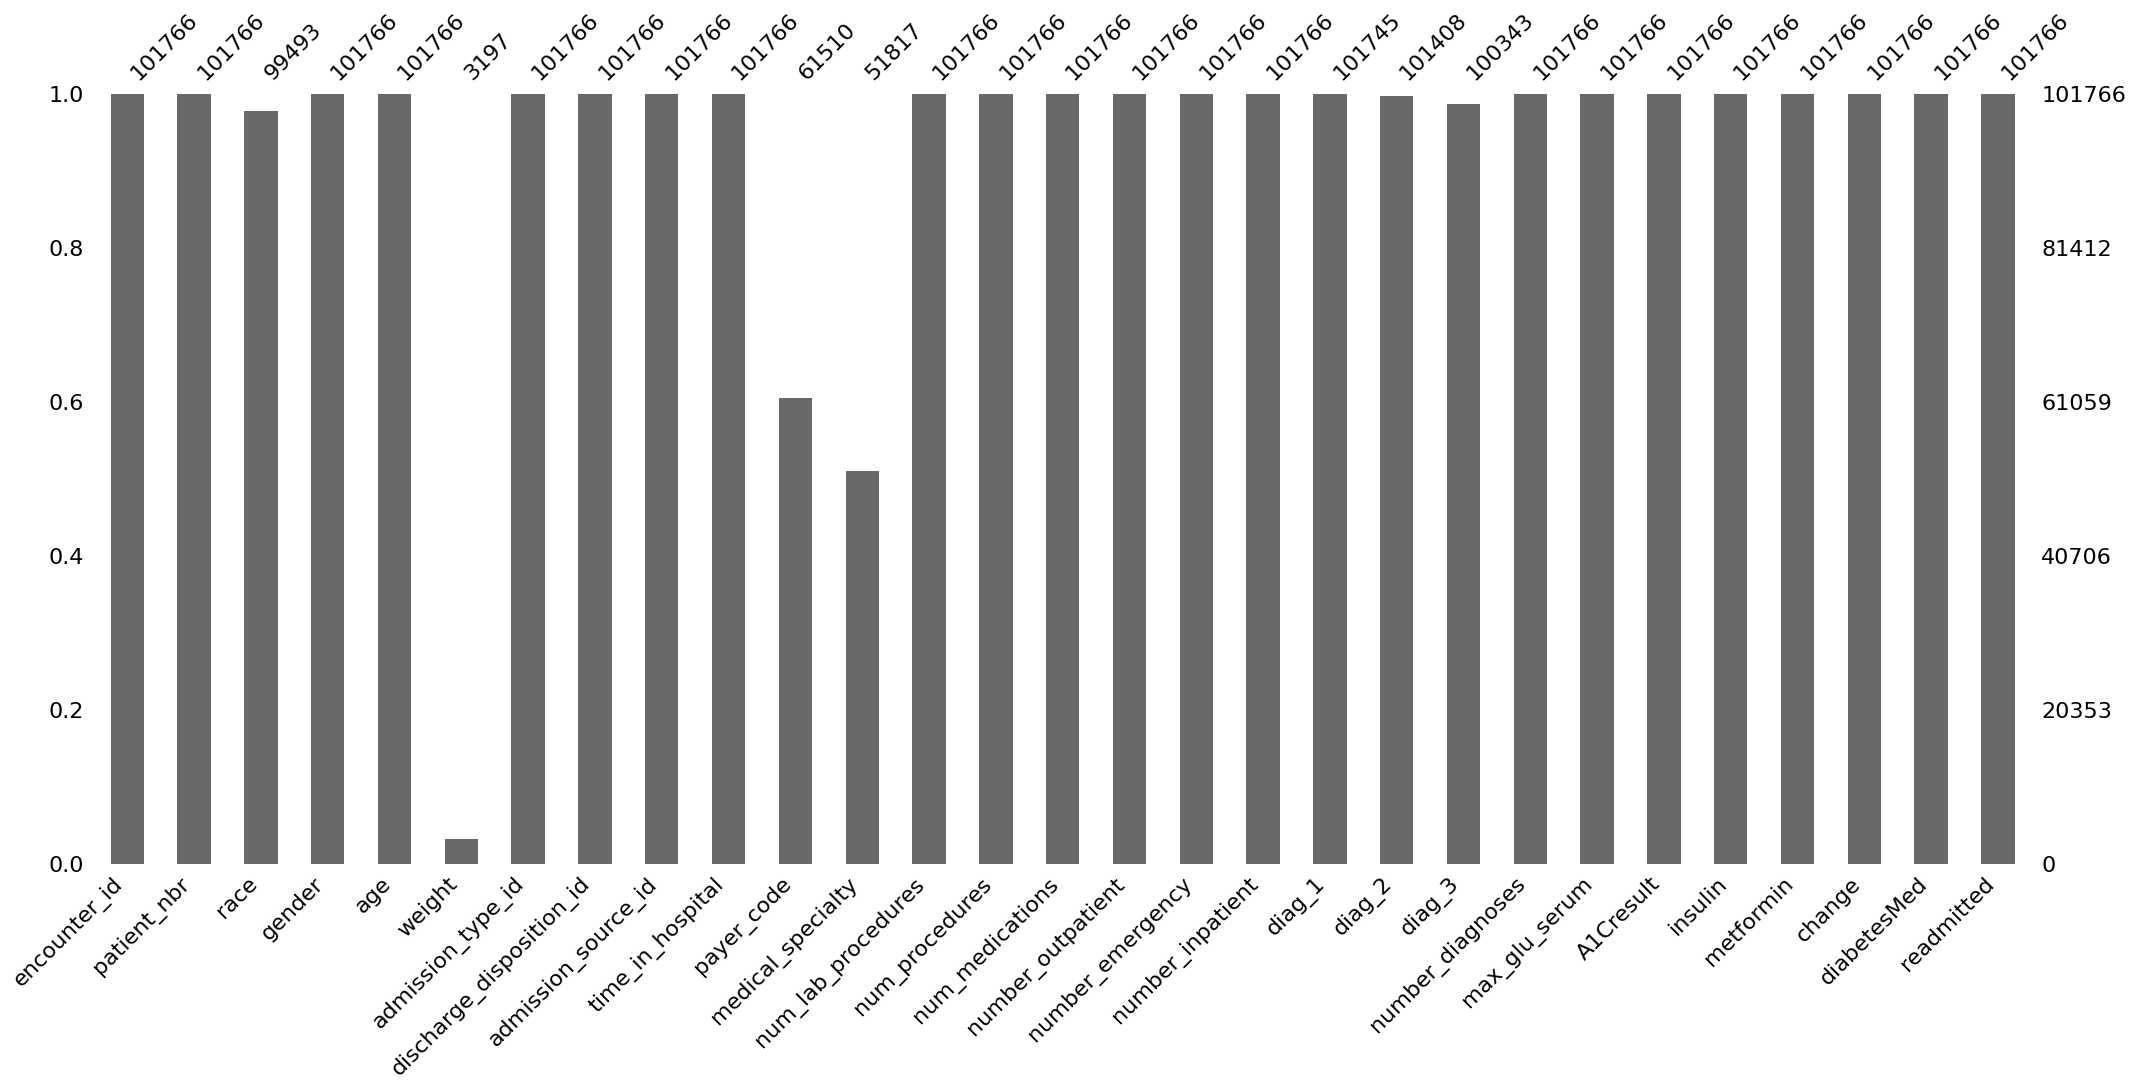

In [ ]:
msno.bar(diabetes)

<AxesSubplot: >

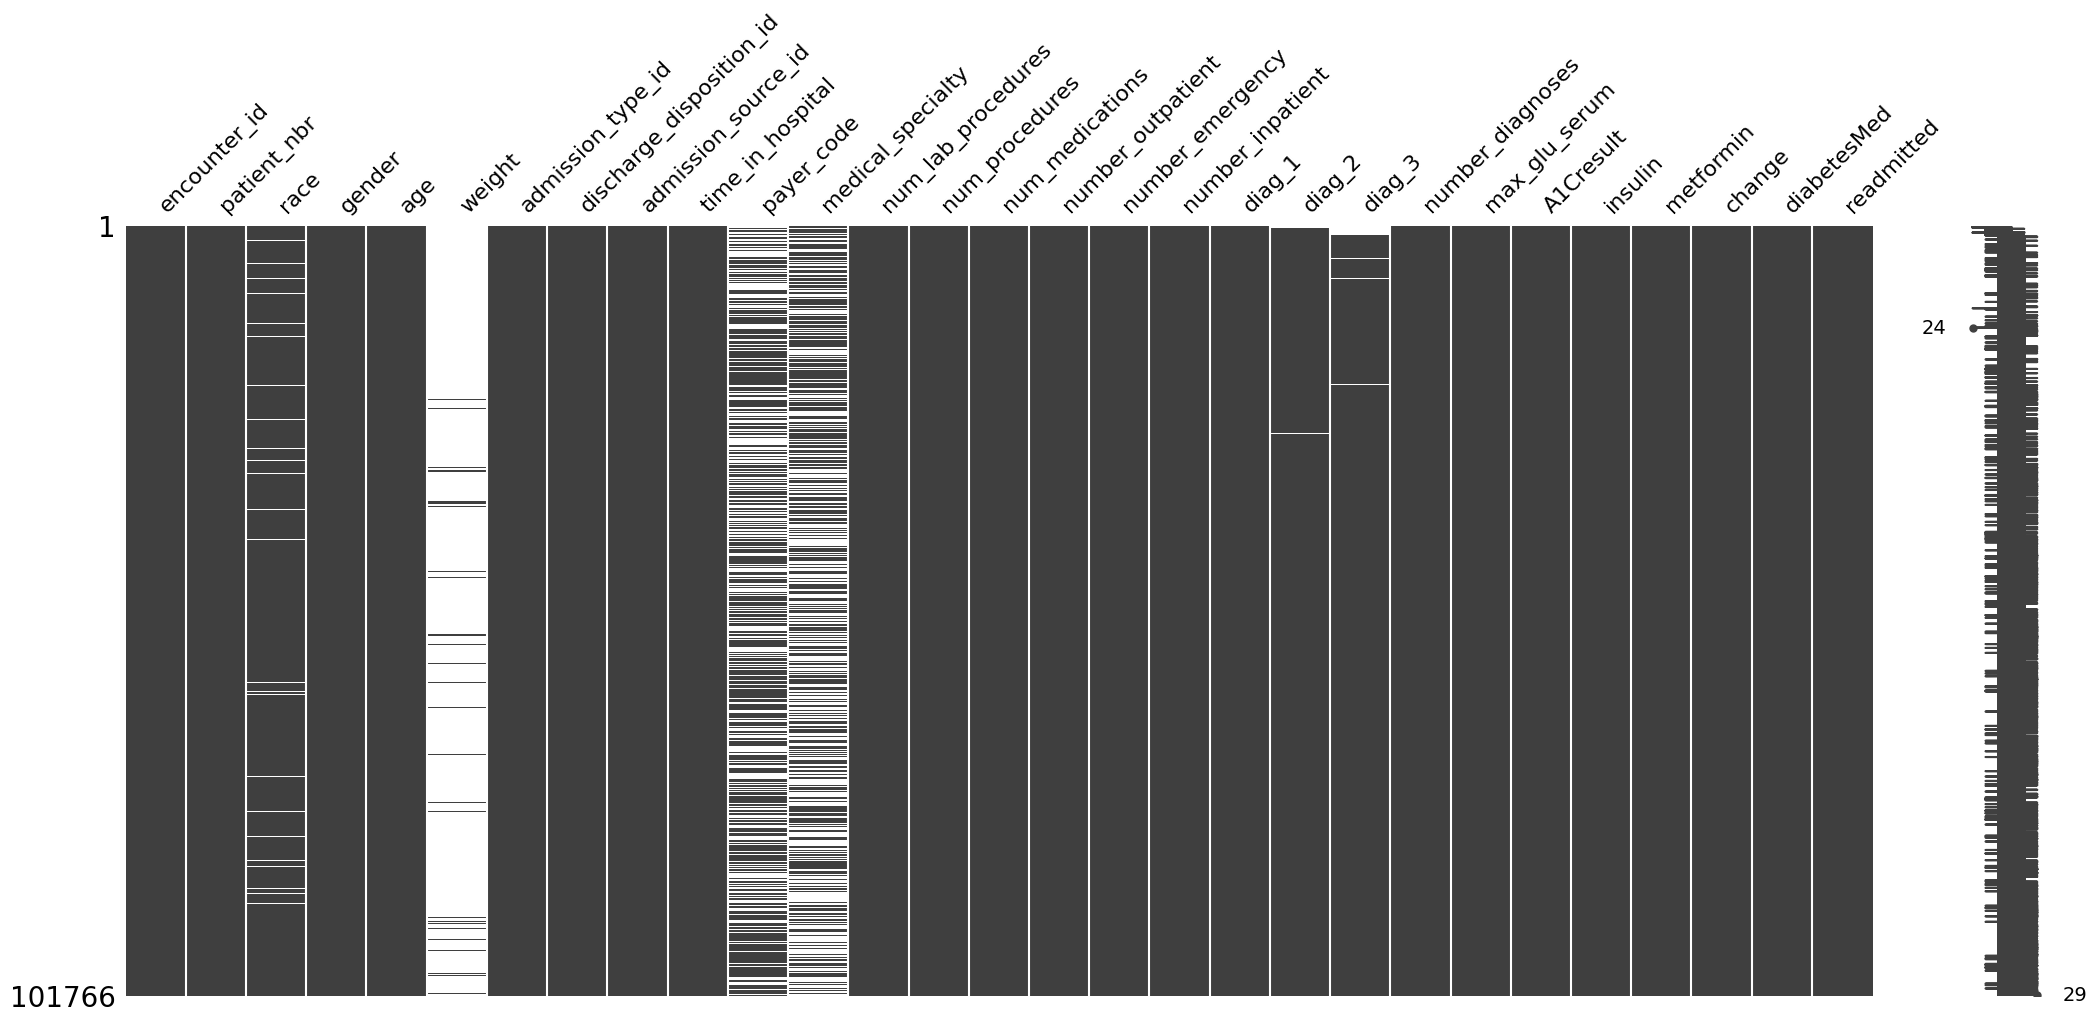

In [ ]:
msno.matrix(diabetes)

# Numerical Features

In [ ]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,metformin,change,diabetesMed,readmitted
0,284318214,43985340,0.0,0,0,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,59649570,17397162,0.0,0,1,NaN,0,0,0,0,...,NaN,NaN,0,0,1,1,1,1,0,0
2,67850904,6196320,0.0,1,1,NaN,0,0,0,0,...,NaN,NaN,0,0,1,1,1,1,0,0
3,86008308,6970950,1.0,0,2,NaN,0,0,0,0,...,NaN,NaN,0,0,0,2,0,0,0,0
4,17130798,14532273,0.0,0,1,NaN,0,0,0,0,...,NaN,NaN,0,0,1,1,1,1,0,0


In [ ]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   encounter_id              101766 non-null  int64  
 1   patient_nbr               101766 non-null  int64  
 2   race                      99493 non-null   float64
 3   gender                    101766 non-null  int64  
 4   age                       101766 non-null  int64  
 5   weight                    3197 non-null    float64
 6   admission_type_id         101766 non-null  int64  
 7   discharge_disposition_id  101766 non-null  int64  
 8   admission_source_id       101766 non-null  int64  
 9   time_in_hospital          101766 non-null  int64  
 10  payer_code                61510 non-null   float64
 11  medical_specialty         51817 non-null   float64
 12  num_lab_procedures        101766 non-null  int64  
 13  num_procedures            101766 non-null  i

In [ ]:
diabetes.describe()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,metformin,change,diabetesMed,readmitted
count,1.017660e+05,1.017660e+05,99493.000000,101766.000000,101766.000000,3197.000000,101766.000000,101766.000000,101766.000000,101766.000000,...,101408.000000,100343.000000,101766.000000,101766.000000,101766.000000,101766.00000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,0.327933,0.537645,6.241937,3.892712,0.919099,2.798764,0.808777,0.867932,...,6.285490,4.826615,2.142415,0.107236,0.291178,1.56794,0.841509,0.538048,0.229969,0.111599
std,1.026403e+08,3.869636e+07,0.733326,0.498642,2.247927,1.475096,1.193494,4.391207,1.499494,1.084813,...,3.828754,4.506648,0.948199,0.484078,0.727473,0.84137,0.433871,0.498553,0.420815,0.314874
min,1.252200e+04,1.350000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,8.496119e+07,2.341322e+07,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000
50%,1.523890e+08,4.550514e+07,0.000000,1.000000,6.000000,4.000000,0.000000,0.000000,0.000000,1.000000,...,7.000000,2.000000,2.000000,0.000000,0.000000,2.00000,1.000000,1.000000,0.000000,0.000000
75%,2.302709e+08,8.754595e+07,0.000000,1.000000,9.000000,5.000000,2.000000,4.000000,1.000000,1.000000,...,7.000000,8.000000,3.000000,0.000000,0.000000,2.00000,1.000000,1.000000,0.000000,0.000000
max,4.438672e+08,1.895026e+08,4.000000,2.000000,9.000000,9.000000,7.000000,25.000000,16.000000,4.000000,...,18.000000,18.000000,5.000000,3.000000,3.000000,3.00000,3.000000,1.000000,1.000000,1.000000


### Skewness

In [ ]:
diabetes.skew()

encounter_id                 0.699142
patient_nbr                  0.471281
race                         3.047696
gender                      -0.150298
age                         -0.601494
weight                      -0.300511
admission_type_id            1.193724
discharge_disposition_id     1.373311
admission_source_id          3.496705
time_in_hospital             1.279599
payer_code                   0.955927
medical_specialty            1.869624
num_lab_procedures           0.346238
num_procedures               1.215179
num_medications              0.992363
number_outpatient           16.018163
number_emergency            35.774946
number_inpatient             4.325732
diag_1                       1.180207
diag_2                       0.859018
diag_3                       1.069293
number_diagnoses            -0.550013
max_glu_serum                4.707242
A1Cresult                    2.590818
insulin                     -0.258907
metformin                   -0.380846
change      

### Univariate Analysis

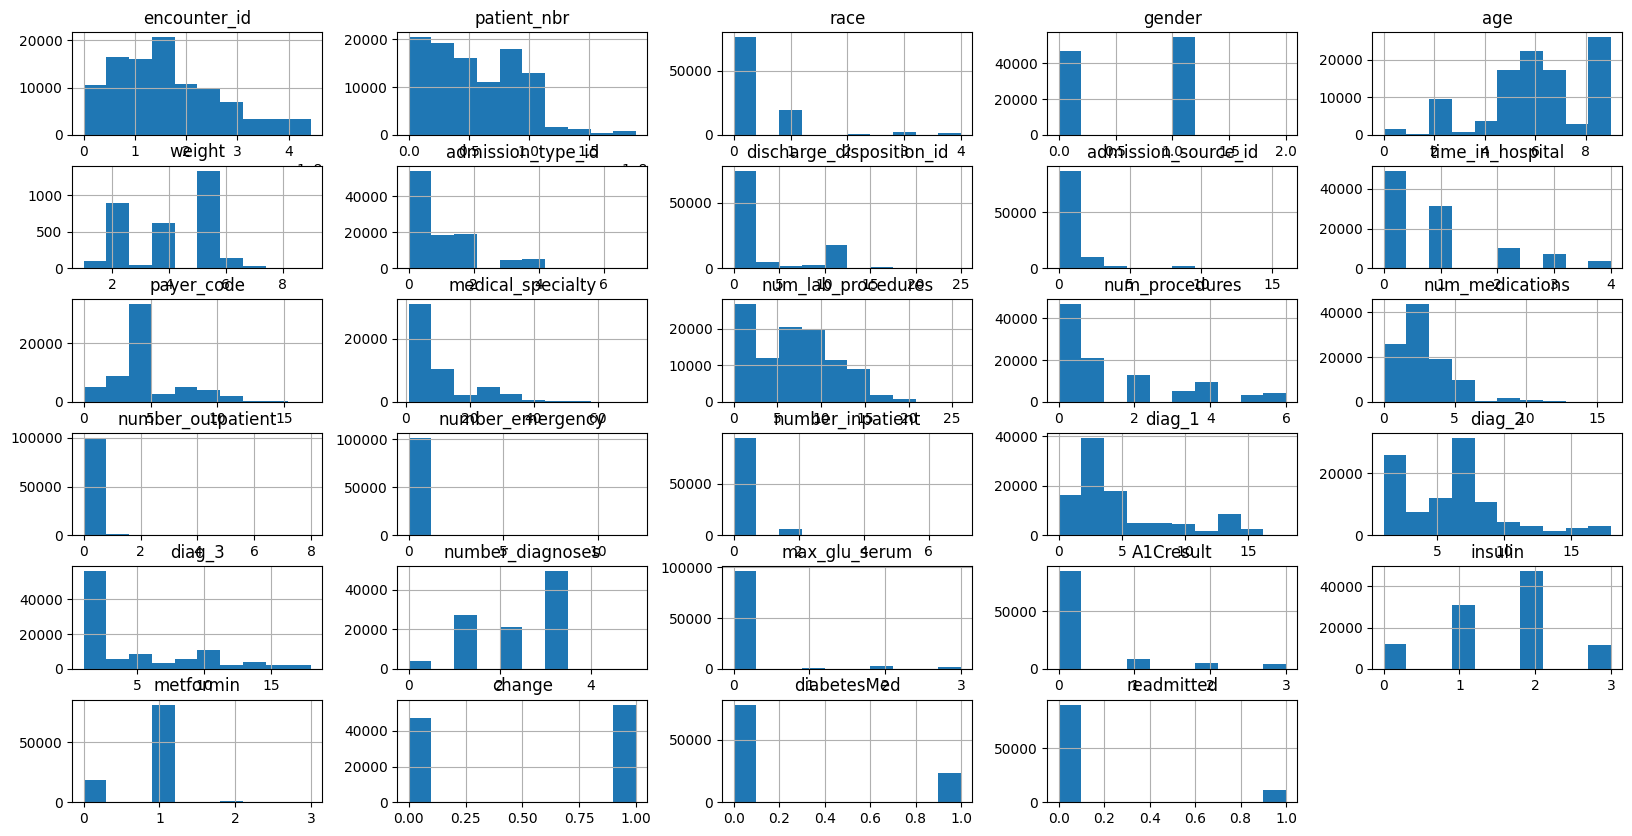

In [ ]:
diabetes.hist(figsize=(20,10));

### Correlation Matrix & Scatter Plots

In [ ]:
diabetes.corr()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,metformin,change,diabetesMed,readmitted
encounter_id,1.000000,0.512028,-0.011299,-0.005974,0.037587,0.043929,-0.145579,0.039627,-0.194206,-0.061619,...,0.061242,0.059496,0.272009,-0.158636,0.034317,-0.002038,-0.038117,-0.096372,-0.051817,-0.008519
patient_nbr,0.512028,1.000000,-0.006351,-0.006577,0.039920,0.011765,-0.008466,0.036419,-0.140125,-0.025524,...,0.048444,0.046347,0.224676,-0.099987,0.017919,0.008971,-0.018701,-0.054842,-0.017232,0.007893
race,-0.011299,-0.006351,1.000000,0.029427,-0.118554,-0.026392,-0.033087,-0.060464,-0.018972,-0.004130,...,-0.013695,0.000559,-0.079784,-0.022571,0.024284,-0.011013,0.000197,-0.011775,-0.006137,-0.007020
gender,-0.005974,-0.006577,0.029427,1.000000,0.024596,-0.174496,-0.016703,0.063041,0.003070,0.024123,...,0.013637,0.015369,0.002076,0.001737,-0.014588,-0.003379,-0.001559,0.014832,0.015945,0.002877
age,0.037587,0.039920,-0.118554,0.024596,1.000000,-0.021752,0.009563,0.223630,0.022628,0.081401,...,0.071756,-0.011982,0.177048,0.035523,-0.049196,0.029977,0.021755,0.028424,0.006835,0.013637
weight,0.043929,0.011765,-0.026392,-0.174496,-0.021752,1.000000,0.012260,-0.123650,-0.107832,-0.024736,...,0.002408,-0.039080,0.028569,NaN,0.020845,0.003272,-0.070466,-0.051900,-0.046316,-0.009224
admission_type_id,-0.145579,-0.008466,-0.033087,-0.016703,0.009563,0.012260,1.000000,-0.019123,0.270547,-0.004609,...,0.042362,-0.000883,-0.135871,0.345985,-0.058895,0.035863,-0.013167,-0.009434,-0.000346,-0.012530
discharge_disposition_id,0.039627,0.036419,-0.060464,0.063041,0.223630,-0.123650,-0.019123,1.000000,0.043374,0.216639,...,0.055765,0.079016,0.176298,0.080594,-0.028826,0.006505,0.041139,-0.020550,0.004470,0.059374
admission_source_id,-0.194206,-0.140125,-0.018972,0.003070,0.022628,-0.107832,0.270547,0.043374,1.000000,0.046007,...,0.028887,-0.006135,-0.084294,0.113064,-0.053776,-0.007663,0.015977,0.033550,0.007166,-0.011453
time_in_hospital,-0.061619,-0.025524,-0.004130,0.024123,0.081401,-0.024736,-0.004609,0.216639,0.046007,1.000000,...,0.043154,0.086114,0.202012,0.004234,0.058055,-0.005576,0.031252,-0.099651,-0.053862,0.041020


In [ ]:
corr = diabetes.corr()
diabetes[diabetes.columns[1:]].corr()['readmitted'].sort_values(ascending=False)[:10]

readmitted                  1.000000
number_inpatient            0.129162
discharge_disposition_id    0.059374
number_diagnoses            0.046624
time_in_hospital            0.041020
num_medications             0.034486
number_emergency            0.028937
diag_3                      0.022165
metformin                   0.017549
age                         0.013637
Name: readmitted, dtype: float64

In [ ]:
diabetes.groupby('readmitted').mean()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,metformin,change,diabetesMed
readmitted,,,,,,,,,,,,,,,,,,,,,
0,1.655115e+08,5.422214e+07,0.329763,0.537137,6.231072,3.897535,0.924399,2.706357,0.814864,0.852161,...,4.616984,6.276044,4.791091,2.126746,0.106040,0.295413,1.572941,0.838810,0.541495,0.234014
1,1.627347e+08,5.519219e+07,0.313457,0.541692,6.328432,3.854342,0.876904,3.534384,0.760324,0.993484,...,4.654422,6.360611,5.107492,2.267148,0.116756,0.257462,1.528132,0.862992,0.510610,0.197763


# Clean the Data

### Step 1: Drop the columns that are either missing most of the times or are not relevant


In [ ]:
diabetes.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'metformin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [ ]:
# Dropping the columns which are not required
diabetes.drop(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
           'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 
           'num_medications', 'time_in_hospital', 'number_outpatient', 'diag_1', 'diag_2', 'diag_3', 'number_emergency', 'number_inpatient', 
           'number_diagnoses', 'metformin', 'change'], axis = 1, inplace = True)

In [ ]:
diabetes.head()

,admission_type_id,discharge_disposition_id,admission_source_id,max_glu_serum,A1Cresult,insulin,diabetesMed,readmitted
0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0
2,0,0,0,0,1,1,0,0
3,0,0,0,0,0,2,0,0
4,0,0,0,0,1,1,0,0


In [ ]:
diabetes = diabetes.dropna()

In [ ]:
diabetes.columns

Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed', 'readmitted'],
      dtype='object')

### Step 2: Check for duplicates

In [ ]:
diabetes.duplicated().sum()

97401

### Step 3: Check for missing data

In [ ]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   admission_type_id         101766 non-null  int64
 1   discharge_disposition_id  101766 non-null  int64
 2   admission_source_id       101766 non-null  int64
 3   max_glu_serum             101766 non-null  int64
 4   A1Cresult                 101766 non-null  int64
 5   insulin                   101766 non-null  int64
 6   diabetesMed               101766 non-null  int64
 7   readmitted                101766 non-null  int64
dtypes: int64(8)
memory usage: 7.0 MB


# Breaking the data up into Train & Test

In [ ]:
train_df, valid_df, test_df = np.split(diabetes.sample(frac=1, random_state=42), 
                                       [int(.7*len(diabetes)), int(0.85*len(diabetes))])
train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [ ]:
diabetes.readmitted.value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

In [ ]:
train_df.readmitted.value_counts()

0    63325
1     7911
Name: readmitted, dtype: int64

In [ ]:
valid_df.readmitted.value_counts()

0    13529
1     1736
Name: readmitted, dtype: int64

In [ ]:
test_df.readmitted.value_counts()

0    13555
1     1710
Name: readmitted, dtype: int64

# Treating the Imbalance in the Data

In [ ]:
def calc_prevalence(y_actual):    
    return (sum(y_actual)/len(y_actual))

In [ ]:
rows_pos = train_df.readmitted == 1
df_train_pos = train_df.loc[rows_pos]
df_train_neg = train_df.loc[~rows_pos]

diabetes_df_balanced = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 111)],axis = 0)

diabetes_df_balanced = diabetes_df_balanced.sample(n = len(diabetes_df_balanced), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(diabetes_df_balanced), \
                                                calc_prevalence(diabetes_df_balanced.readmitted.values)))

Train balanced prevalence(n = 15822):0.500


In [ ]:
diabetes_df_balanced.readmitted.value_counts()

0    7911
1    7911
Name: readmitted, dtype: int64

In [ ]:
X_train = diabetes_df_balanced.drop('readmitted',axis=1)

y_train = diabetes_df_balanced['readmitted']

X_valid = valid_df.drop('readmitted',axis=1)

y_valid = valid_df['readmitted']

X_test = test_df.drop('readmitted',axis=1)

y_test = test_df['readmitted']

In [ ]:
scaler=StandardScaler()
X_train[['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed']] = pd.DataFrame(scaler.fit_transform(X_train[['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed']]), columns=['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed'])
X_valid[['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed']] = pd.DataFrame(scaler.transform(X_valid[['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed']]), columns=['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed'])
X_test[['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed']] = pd.DataFrame(scaler.transform(X_test[['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed']]), columns=['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'max_glu_serum', 'A1Cresult', 'insulin', 'diabetesMed'])

# Creating and Understanding Models

In [ ]:
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh = 0.5):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

## Linear Regression

In [ ]:
lnr = LinearRegression()
lnr.fit(X_train, y_train)


y_valid_preds = lnr.predict(X_valid)

In [ ]:
y_valid_preds

array([0.53105644, 0.50435954, 0.46904026, ..., 0.48449608, 0.47945581,
       0.61178383])

## Logistic Regression

In [ ]:
lr=LogisticRegression(random_state = 42, solver = 'newton-cg', max_iter = 200)
lr.fit(X_train, y_train)

y_valid_preds = lr.predict_proba(X_valid)[:,1]

print('Metrics for Validation data:')

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, 0.5)

Metrics for Validation data:
AUC:0.564
accuracy:0.549
recall:0.546
precision:0.134
specificity:0.549
prevalence:0.114
 


## KNN Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train, y_train)

knn_preds = knn.predict_proba(X_valid)[:,1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,knn_preds, 0.5)

AUC:0.576
accuracy:0.615
recall:0.497
precision:0.147
specificity:0.542
prevalence:0.114
 


## K-Means Model

In [ ]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_train)
kmeans_preds = kmeans.predict(X_valid)

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,kmeans_preds, 0.5)

AUC:0.490
accuracy:0.327
recall:0.736
precision:0.115
specificity:0.275
prevalence:0.114
 


## Stochastic Gradient Descent Model

In [ ]:
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train, y_train)

sgd_preds = sgdc.predict_proba(X_valid)[:,1]

print('Stochastic Gradient Descent')
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, \
                sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,sgd_preds, 0.5)

Stochastic Gradient Descent
Validation:
AUC:0.564
accuracy:0.564
recall:0.529
precision:0.136
specificity:0.568
prevalence:0.114
 


## Decision Tree

In [ ]:
dc_clf = DecisionTreeClassifier(random_state=42, max_depth = 10)
dc_clf.fit(X_train, y_train)

dc_preds_proba = dc_clf.predict_proba(X_valid)[:,1]
dc_preds = dc_clf.predict(X_valid)

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,dc_preds_proba, 0.5)

AUC:0.594
accuracy:0.614
recall:0.507
precision:0.149
specificity:0.621
prevalence:0.114
 


## Random Forest

In [ ]:
rf_clf = RandomForestClassifier(random_state=111, max_depth = 6)

rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_valid)
rf_preds_proba = rf_clf.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,rf_preds_proba, 0.5)

AUC:0.599
accuracy:0.584
recall:0.555
precision:0.147
specificity:0.588
prevalence:0.114
 


## Linear SVC

In [ ]:
lsvc_clf = LinearSVC(random_state=111)
lsvc_clf.fit(X_train, y_train)

lsvc_preds = lsvc_clf.decision_function(X_valid)

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,lsvc_preds, 0.5)

AUC:0.564
accuracy:0.886
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.114
 


## Gradient Boosting Model

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators = 100, criterion='friedman_mse', learning_rate = 1.0, max_depth = 3,\
                                    random_state = 111)

gb_clf.fit(X_train, y_train)
gb_preds = gb_clf.predict(X_valid)
gb_preds_proba = gb_clf.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,gb_preds_proba, 0.5)

AUC:0.607
accuracy:0.600
recall:0.544
precision:0.151
specificity:0.608
prevalence:0.114
 


## XGB Model

In [ ]:
xgb_clf = xgb.XGBClassifier(max_depth=3, learning_rate = 1.0, use_label_encoder = False,\
                            eval_metric = 'logloss')
xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_valid)
xgb_preds_proba = xgb_clf.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,xgb_preds_proba, 0.5)

AUC:0.602
accuracy:0.595
recall:0.550
precision:0.150
specificity:0.601
prevalence:0.114
 


## Catboost Model

In [ ]:
catb=CatBoostClassifier(iterations=200, depth=3, learning_rate=1.0, random_state = 111)
catb.fit(X_train, y_train)
catb_preds = catb.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,catb_preds, 0.5)

0:	learn: 0.6830671	total: 167ms	remaining: 33.2s
1:	learn: 0.6807131	total: 177ms	remaining: 17.5s
2:	learn: 0.6763434	total: 187ms	remaining: 12.3s
3:	learn: 0.6748549	total: 195ms	remaining: 9.57s
4:	learn: 0.6740484	total: 207ms	remaining: 8.08s
5:	learn: 0.6731873	total: 214ms	remaining: 6.9s
6:	learn: 0.6729879	total: 218ms	remaining: 6s
7:	learn: 0.6720113	total: 224ms	remaining: 5.37s
8:	learn: 0.6719043	total: 230ms	remaining: 4.88s
9:	learn: 0.6699396	total: 236ms	remaining: 4.48s
10:	learn: 0.6690027	total: 242ms	remaining: 4.15s
11:	learn: 0.6680586	total: 248ms	remaining: 3.88s
12:	learn: 0.6673168	total: 255ms	remaining: 3.67s
13:	learn: 0.6666780	total: 261ms	remaining: 3.47s
14:	learn: 0.6662711	total: 267ms	remaining: 3.3s
15:	learn: 0.6661114	total: 273ms	remaining: 3.14s
16:	learn: 0.6655130	total: 278ms	remaining: 2.99s
17:	learn: 0.6652522	total: 284ms	remaining: 2.88s
18:	learn: 0.6650880	total: 291ms	remaining: 2.77s
19:	learn: 0.6647605	total: 296ms	remaining: 2

# Hyper Parameter Tuning

In [ ]:
recall_scoring = make_scorer(recall_score)

## Decision Tree - Hyper Parameter Tuning

In [ ]:
dc_grid = {'max_features':['auto','sqrt'], 
           'max_depth':range(1,11,1),
           'min_samples_split':range(2,10,2), 
           'criterion':['gini','entropy']} 

dc_random = RandomizedSearchCV(estimator = dc_clf, param_distributions = dc_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

dc_random.fit(X_train, y_train)

dc_random.best_params_

dc_hp_preds = dc_random.best_estimator_.predict(X_valid)
dc_hp_preds_proba = dc_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, dc_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.5191479142092102

In [ ]:
recall_score(y_valid, dc_hp_preds)

0.8047235023041475

## Random Forest - Hyper Parameter Tuning

In [ ]:
rf_grid = {'n_estimators':range(200,1000,200), 
           'max_features':['auto','sqrt'], 
           'max_depth':range(1,11,1), 
           'min_samples_split':range(2,10,2), 
           'criterion':['gini','entropy']}

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

rf_random.fit(X_train, y_train)

rf_random.best_params_

rf_hp_preds = rf_random.best_estimator_.predict(X_valid)
rf_hp_preds_proba = rf_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, rf_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.60189668089678

In [ ]:
recall_score(y_valid, rf_hp_preds)

0.5610599078341014

## XGBoost - Hyper Parameter Tuning

In [ ]:
xgb_grid = params = {
        'min_child_weight': [1, 5, 8, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5]
        } 

xgb_random = GridSearchCV(estimator = xgb_clf, param_grid = xgb_grid, 
                               cv = 2, scoring = recall_scoring,
                               verbose = 1)

xgb_random.fit(X_train, y_train)

xgb_random.best_params_

xgb_hp_preds = xgb_random.best_estimator_.predict(X_valid)
xgb_hp_preds_proba = xgb_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, xgb_hp_preds_proba)

Fitting 2 folds for each of 720 candidates, totalling 1440 fits


0.601585265888978

In [ ]:
recall_score(y_valid, xgb_hp_preds)

0.6244239631336406